## Dependencies

In [31]:
import tkinter as tk
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from collections import defaultdict
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

## Data Preprocessing
Tahap ini mencakup prapemrosesan data teks pada setiap poin dataset agar lebih mudah dianalisis. Proses-proses yang dilakukan mencakup casefolding, tokenisasi, stop word removal, dan lemmatisasi.

In [3]:
# Hilangkan simbol dan tanda baca
def remove_punctuation(text):
    # remove punctuation using string library
    text = "".join([char for char in text if char not in string.punctuation])
    # remove certain characters
    text = re.sub(r'\s+', ' ', text)
    return text

# Get wordnet pos tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# Prapemrosesan teks
def preprocess_text(text, lang = 'english'):
    # Casefolding
    text = remove_punctuation(text.lower())

    # Tokenization
    words = word_tokenize(text)

    # Stop word removal
    stop_words = set(stopwords.words(lang)) # => ("is", "that", "at", ...)
    words = [word for word in words if word not in stop_words]

    #POS_tagger
    tagged = pos_tag(words)

    # lemmatizer
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(word[0], pos = get_wordnet_pos(word[1]) or wordnet.NOUN) for word in tagged]

    # Hubungkan kembali kata2 yang sudah di proses (opsional)
    result = ' '.join(words)

    return result

#### Contoh Hasil Prapemrosesan Data:

In [4]:
text = "This is an examples of text preprocessing using NLTK. It includes casefolding, tokenization, stopword removal, and stemming."
preprocessed_text = preprocess_text(text, 'english')
print(preprocessed_text)

examples text preprocessing using nltk includes casefolding tokenization stopword removal stemming


#### Prapemrosesan Dataset:

In [50]:
journalDtf = pd.read_csv("arxiv_data.csv")[:500]

print("Sebelum preprocessing:")
print(journalDtf['summaries'].head())

journalDtf['summaries'] = journalDtf['summaries'].apply(preprocess_text)

print("\nSetelah preprocessing:")
print(journalDtf['summaries'].head())

Sebelum preprocessing:
0    Stereo matching is one of the widely used tech...
1    The recent advancements in artificial intellig...
2    In this paper, we proposed a novel mutual cons...
3    Consistency training has proven to be an advan...
4    To ensure safety in automated driving, the cor...
Name: summaries, dtype: object

Setelah preprocessing:
0    stereo matching one widely used techniques inf...
1    recent advancements artificial intelligence ai...
2    paper proposed novel mutual consistency networ...
3    consistency training proven advanced semisuper...
4    ensure safety automated driving correct percep...
Name: summaries, dtype: object


## Ekstraksi Fitur

Ekstraksi fitur dilakukan dengan menghitung vektor bobot TF-IDF untuk setiap data teks yang sudah terproses.

In [114]:
t0 = time()

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(journalDtf['summaries'])

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.051 s
n_samples: 500, n_features: 7374


#### Dimensionality Reduction Menggunakan LSA (*Latent Semantic Analysis*)
Tahap ini dilakukan untuk mengurangi dimensi dari dataset agar dapat mempercepat algoritma clustering.

In [116]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.236 s
Explained variance of the SVD step: 36.1%


#### Pencarian K menggunakan *Elbow Method* dengan *Cosine Similarity* 
Tahap ini dilakukan untuk mengetahui nilai K yang dapat digunakan untuk algoritma clustering. Perhitungan dilakukan dengan menghitung nilai distorsi pada setiap nilai k untuk mencari posisi "siku" dalam grafik yang ada. Untuk membantu dalam perhitungan, nilai jarak yang digunakan adalah *cosine distance*, yang merupakan nilai komplemen dari *Cosine Similarity*.


In [117]:
# Jarak antar poin ditetapkan sebagai invers dari nilai cosine similarity
X_cosine_distance = 1 - pairwise_distances(X_lsa, metric='cosine')
inertias = []
K_values = range(1, 100)

for k in K_values:
    kmeans_model = KMeans(n_clusters=k, n_init=1)
    kmeans_model.fit(X_cosine_distance)

    inertias.append(kmeans_model.inertia_)

print("Done!")

Done!


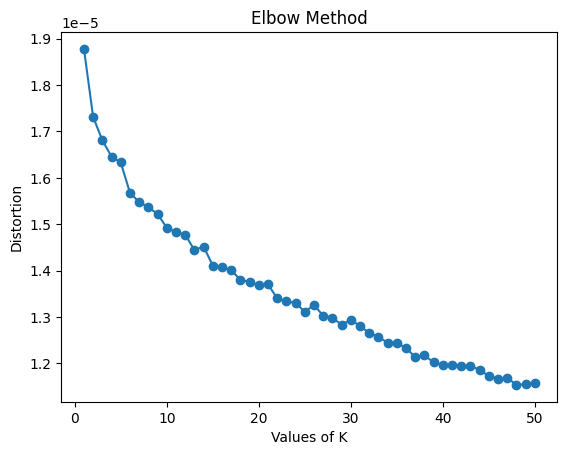

In [121]:
upper_bound = 50
inertias = [i/X_cosine_distance.shape[0] for i in inertias]

plt.plot(K_values[:upper_bound], inertias[:upper_bound], 'o-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

Dengan mempertimbangkan hasil grafik dari antara distorsi dan nilai K. Nilai K yang dapat diambil adalah 2 \<= K \<= 20

## Evaluasi

#### Silhouette Score

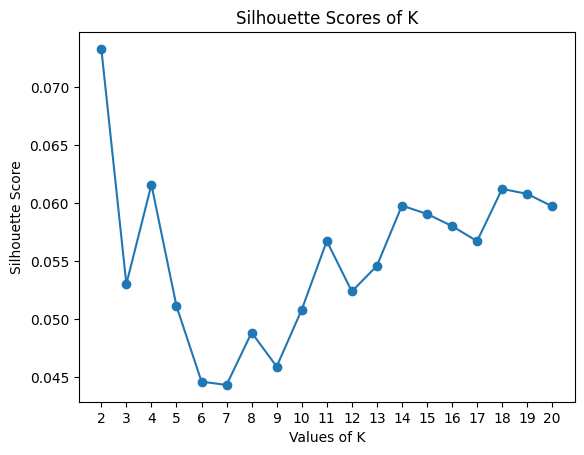

In [126]:
K_values = range(2, 21)
scores = []

for k in K_values:
    kmeans_model = KMeans(n_clusters=k, n_init=10)
    kmeans_model.fit(X_cosine_distance)
    scores.append(metrics.silhouette_score(X_cosine_distance, kmeans_model.labels_, sample_size=500))

plt.plot(K_values, scores, 'o-')
plt.xticks(K_values)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores of K')
plt.show()

Dari hasil perhitungan silhouette score berbagai nilai K berbeda didapatkan nilai K terbaik K = 2

#### Top Terms per clusters

In [129]:
kmeans_model = KMeans(n_clusters=2, n_init=10)
kmeans_model.fit(X_tfidf)

order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(2):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: segmentation data learning medical training domain image images labels model 
Cluster 1: segmentation image network method semantic images proposed model results methods 
